In [77]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn import model_selection
import imblearn
from sklearn.model_selection import GridSearchCV
import jupyternotify
from sklearn import tree

In [2]:
%%time
# load dataset
sepsis_df = pd.read_csv('s41598-020-73558-3_sepsis_survival_primary_cohort.csv')
#Let's rename these variables to make it easier:
sepsis_df.rename(columns={'age_years':'age', 'sex_0male_1female':'sex', 'hospital_outcome_1alive_0dead':'outcome'})

#And let's declare what's our x and y columns
x = sepsis_df[['age_years', 'sex_0male_1female','episode_number']]
y = sepsis_df['hospital_outcome_1alive_0dead']


CPU times: total: 15.6 ms
Wall time: 25 ms


In [3]:
%%time
#verify that x and y are correctly configured
print(x.head)
print(y.head)

<bound method NDFrame.head of         age_years  sex_0male_1female  episode_number
0              21                  1               1
1              20                  1               1
2              21                  1               1
3              77                  0               1
4              72                  0               1
...           ...                ...             ...
110199          0                  0               1
110200          0                  1               1
110201         70                  1               1
110202          0                  0               1
110203          0                  0               1

[110204 rows x 3 columns]>
<bound method NDFrame.head of 0         1
1         1
2         1
3         1
4         1
         ..
110199    1
110200    1
110201    1
110202    1
110203    1
Name: hospital_outcome_1alive_0dead, Length: 110204, dtype: int64>
CPU times: total: 0 ns
Wall time: 3.99 ms


In [4]:
#Great, they're set up correctly. Let's check the balance of the dataset.

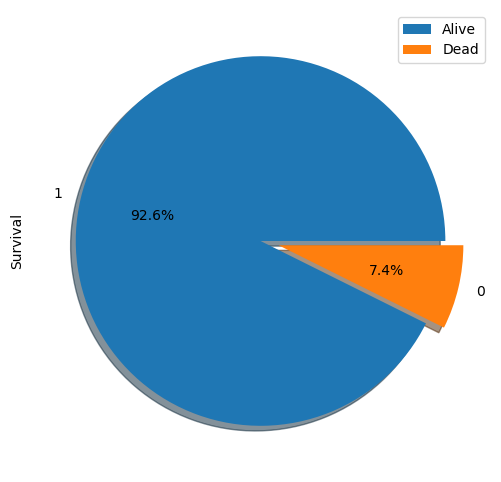

CPU times: total: 46.9 ms
Wall time: 120 ms


In [5]:
%%time
# examine the dataset's balance
def show_data_balance(data):
  count = ""
  if isinstance(data, pd.DataFrame):
      count = data["hospital_outcome_1alive_0dead"].value_counts()
  else:
      count = data.value_counts()


  count.plot(kind = 'pie', explode = [0, 0.1], 

              figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
  plt.ylabel("Survival")
  plt.legend(["Alive", "Dead"])
  plt.show()


# Visualize the proportion of patients
show_data_balance(sepsis_df)

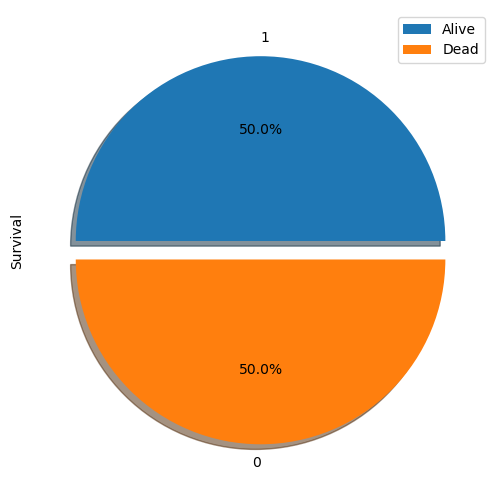

204198 110204 age_years            204198
sex_0male_1female    204198
episode_number       204198
dtype: int64 age_years            110204
sex_0male_1female    110204
episode_number       110204
dtype: int64
CPU times: total: 0 ns
Wall time: 114 ms


In [6]:
%%time
smote = imblearn.over_sampling.SMOTE(sampling_strategy='auto')
x_SMOTE, y_SMOTE = smote.fit_resample(x,y)
# Visualize the proportion of borrowers
show_data_balance(y_SMOTE)
print(y_SMOTE.count(), y.count(), x_SMOTE.count(), x.count())

In [7]:
%%time
#reassign data
#Since we've redone the dataset to be balanced, now re-split the dataset
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_SMOTE,y_SMOTE,test_size =0.3)

#and check the counts again
print(x_train_smote.count())
print(y_train_smote.count())
#both should be 70% of x.count

age_years            142938
sex_0male_1female    142938
episode_number       142938
dtype: int64
142938
CPU times: total: 15.6 ms
Wall time: 19.7 ms


In [8]:
%%time
# Now for the first model. Since this is a cut and dry binary classification task (dead or not dead), the first model to try 
#is the logistic regression. We've imported it above, so now let's create it
log_reg = LogisticRegression()

#It's been created, so now we fit the model
log_reg.fit(x_train_smote,y_train_smote)

CPU times: total: 562 ms
Wall time: 202 ms


LogisticRegression()

In [9]:
%%time
#great, we have a model! now, predict something

y_pred_logreg_smote = log_reg.predict(x_test_smote)

CPU times: total: 0 ns
Wall time: 3.99 ms


In [10]:
%%time
#We've imported metrics up top, so now we can generate a confusion matrix on how well it did.
conf_matrix_logreg_smote = metrics.confusion_matrix(y_test_smote, y_pred_logreg_smote)

CPU times: total: 15.6 ms
Wall time: 10.5 ms


CPU times: total: 15.6 ms
Wall time: 64.2 ms


Text(0.5, 427.9555555555555, 'Predicted')

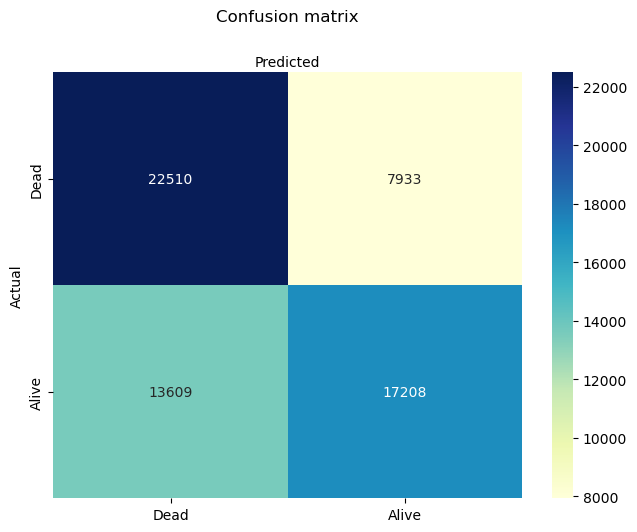

In [86]:
%%time
#Yikes, that doesn't look good. Let's make it pretty
class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_logreg_smote), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); 
ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#1 = alive, 0 = dead

In [12]:
%%time
# Cool, but let's quantify this in numbers
target_names = ['Dead','Alive']
print(metrics.classification_report(y_test_smote,y_pred_logreg_smote,target_names=target_names))

              precision    recall  f1-score   support

        Dead       0.62      0.74      0.68     30443
       Alive       0.68      0.56      0.62     30817

    accuracy                           0.65     61260
   macro avg       0.65      0.65      0.65     61260
weighted avg       0.65      0.65      0.65     61260

CPU times: total: 0 ns
Wall time: 61.3 ms


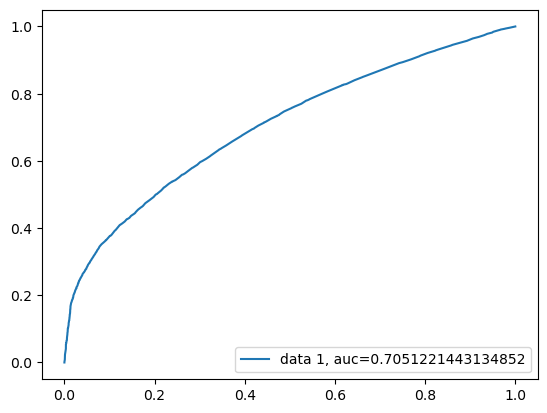

CPU times: total: 328 ms
Wall time: 114 ms


In [13]:
%%time
#Neat, those numbers are bad! But let's do a ROC curve for funsies
y_pred_proba_logreg_smote = log_reg.predict_proba(x_test_smote)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_smote,  y_pred_proba_logreg_smote)
auc = metrics.roc_auc_score(y_test_smote, y_pred_proba_logreg_smote)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [14]:
%%time
# Well, logistic regression was bad! Let's try SVM
clf = svm.SVC(kernel = 'linear')
clf = clf.fit(x_train_smote,y_train_smote)
y_pred_svm_smote = clf.predict(x_test_smote)

CPU times: total: 21min 35s
Wall time: 36min 12s


In [15]:
%%time

print(metrics.classification_report(y_test_smote,y_pred_svm_smote,target_names=target_names))
conf_matrix_svm_smote = metrics.confusion_matrix(y_test_smote, y_pred_svm_smote)


              precision    recall  f1-score   support

        Dead       0.61      0.81      0.70     30443
       Alive       0.72      0.48      0.58     30817

    accuracy                           0.65     61260
   macro avg       0.66      0.65      0.64     61260
weighted avg       0.67      0.65      0.64     61260

CPU times: total: 0 ns
Wall time: 72.6 ms


CPU times: total: 31.2 ms
Wall time: 70.3 ms


Text(0.5, 427.9555555555555, 'Predicted')

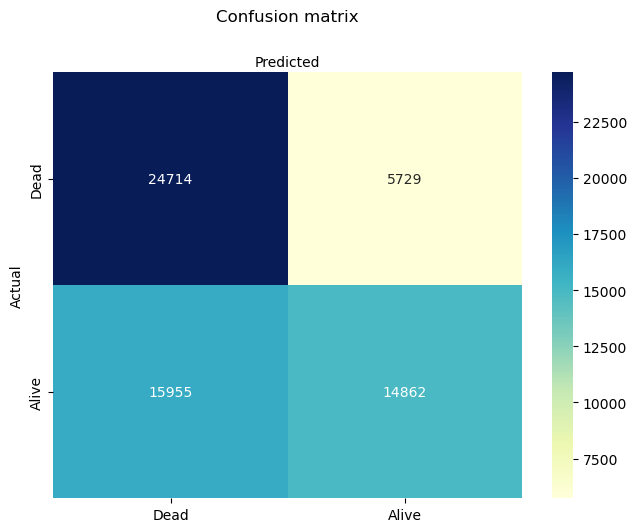

In [16]:
%%time

class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_svm_smote), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

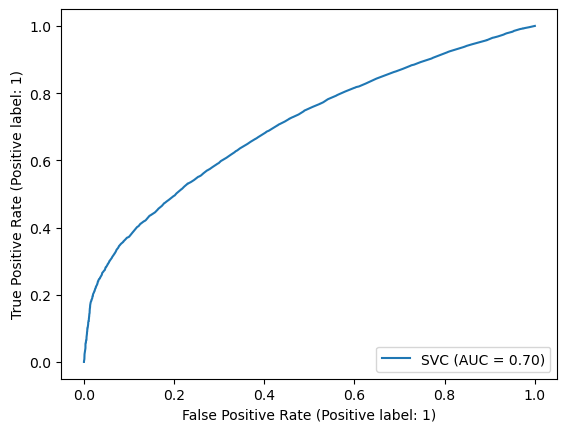

CPU times: total: 59.2 s
Wall time: 1min 50s


In [17]:
%%time

#Let's do a cheeky curve
svm_disp = metrics.RocCurveDisplay.from_estimator(clf, x_test_smote, y_test_smote)
plt.show()

In [18]:
%%time

#That's even worse!! Let's do a decision tree
clf_tree_smote = DecisionTreeClassifier()
clf_tree_smote = clf_tree_smote.fit(x_train_smote, y_train_smote)
y_pred_tree_smote = clf_tree_smote.predict(x_test_smote)

CPU times: total: 15.6 ms
Wall time: 53.3 ms


In [87]:
path = clf_tree_smote.cost_complexity_pruning_path(x_train_smote, y_train_smote)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

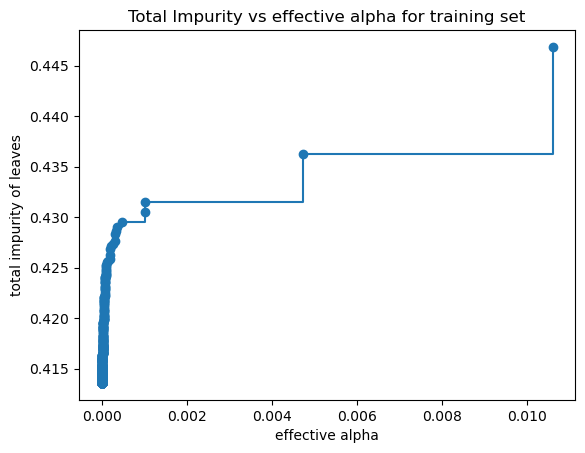

In [88]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [90]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train_smote, y_train_smote)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.05315270265924299


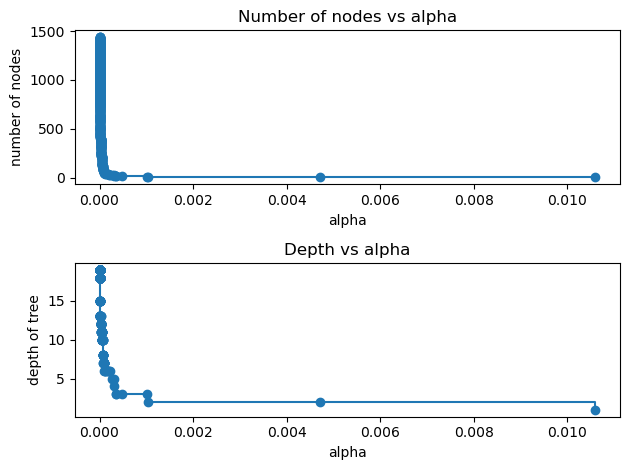

In [91]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

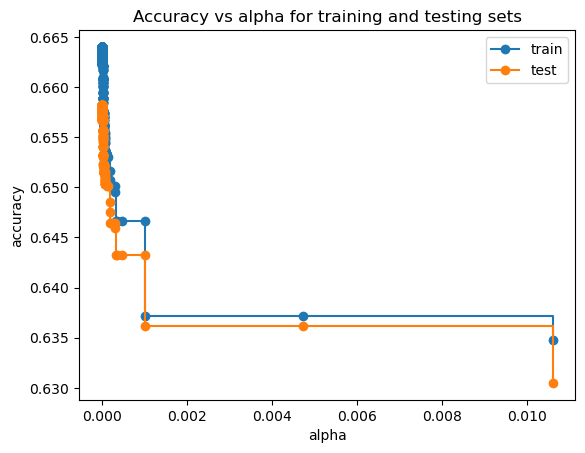

In [92]:
train_scores = [clf.score(x_train_smote, y_train_smote) for clf in clfs]
test_scores = [clf.score(x_test_smote, y_test_smote) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [19]:
%%time

print(metrics.classification_report(y_test_smote,y_pred_tree_smote,target_names=target_names))
conf_matrix_tree_smote = metrics.confusion_matrix(y_test_smote, y_pred_tree_smote)

              precision    recall  f1-score   support

        Dead       0.62      0.79      0.70     30443
       Alive       0.72      0.53      0.61     30817

    accuracy                           0.66     61260
   macro avg       0.67      0.66      0.65     61260
weighted avg       0.67      0.66      0.65     61260

CPU times: total: 0 ns
Wall time: 67.3 ms


CPU times: total: 15.6 ms
Wall time: 58.6 ms


Text(0.5, 427.9555555555555, 'Predicted')

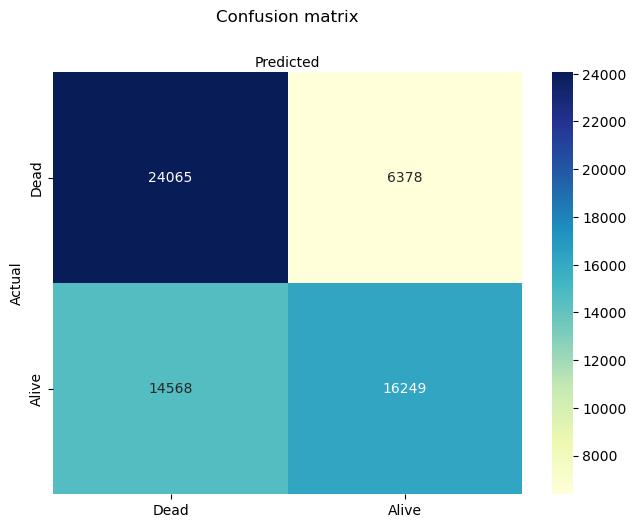

In [20]:
%%time

class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_tree_smote), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); 
ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

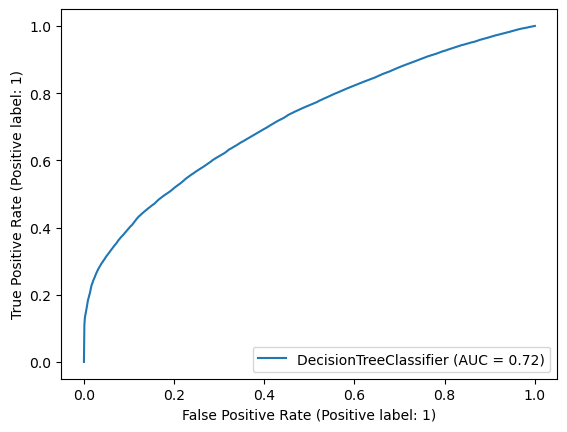

CPU times: total: 15.6 ms
Wall time: 96.9 ms


In [21]:
%%time

tree_disp_smote = metrics.RocCurveDisplay.from_estimator(clf_tree_smote, x_test_smote, y_test_smote)
plt.show()

In [22]:
%%time

#These are just getting worse. Let's try KNN. 
scaler = preprocessing.StandardScaler()
x_train_scale_smote = scaler.fit_transform(x_train_smote)
x_test_scale_smote = scaler.transform(x_test_smote)

CPU times: total: 0 ns
Wall time: 12.4 ms


In [25]:
k_values = [i for i in range (1,100)]
scores = []


for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    score = model_selection.cross_val_score(knn, x_train_scale_smote, y_train_smote, cv=5)
    scores.append(np.mean(score))

CPU times: total: 0 ns
Wall time: 33.9 ms


Text(0, 0.5, 'Accuracy Score')

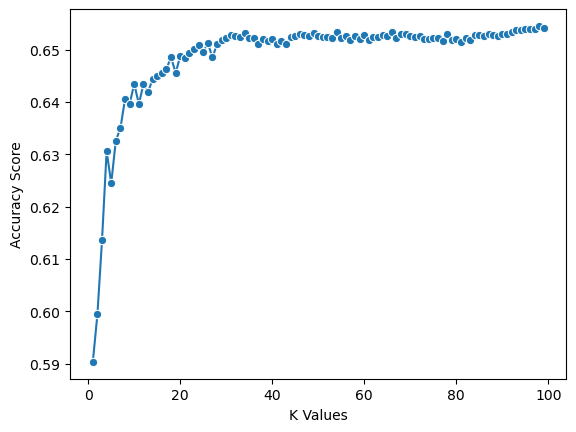

In [26]:
%%time
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [27]:
%%time

knn_smote = neighbors.KNeighborsClassifier(n_neighbors=28)
knn_smote.fit(x_train_scale_smote, y_train_smote)

CPU times: total: 0 ns
Wall time: 89.2 ms


KNeighborsClassifier(n_neighbors=28)

In [30]:
%%time

y_pred_knn_smote = knn_smote.predict(x_test_scale_smote)

CPU times: total: 2.08 s
Wall time: 2.74 s


In [33]:
%%time

print(metrics.classification_report(y_test_smote,y_pred_knn_smote,target_names=target_names))
conf_matrix_knn_smote = metrics.confusion_matrix(y_test_smote, y_pred_knn_smote)
print(metrics.accuracy_score(y_test_smote, y_pred_knn_smote))

              precision    recall  f1-score   support

        Dead       0.61      0.80      0.69     30443
       Alive       0.71      0.50      0.58     30817

    accuracy                           0.65     61260
   macro avg       0.66      0.65      0.64     61260
weighted avg       0.66      0.65      0.64     61260

0.6461965393405158
CPU times: total: 78.1 ms
Wall time: 77.8 ms


CPU times: total: 15.6 ms
Wall time: 57.9 ms


Text(0.5, 427.9555555555555, 'Predicted')

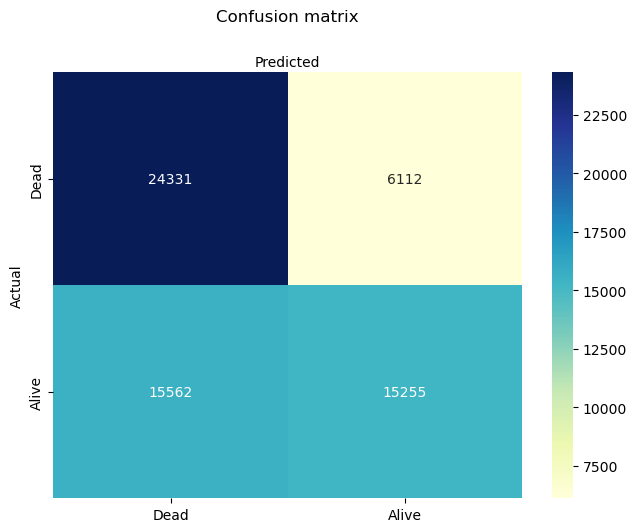

In [34]:
%%time
class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_knn_smote), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

C:\Users\jenni\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


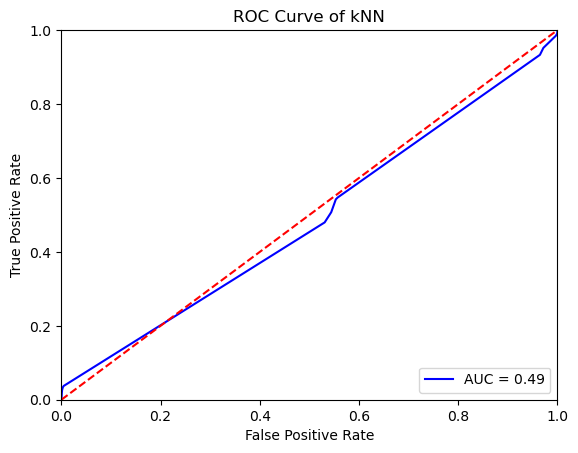

In [95]:
y_scores_smote = knn_smote.predict_proba(x_test_smote)
fpr, tpr, threshold = metrics.roc_curve(y_test_smote, y_scores_smote[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [35]:
#Well, we've done it with SMOTE. Let's try with random undersampling and see if this helps.

In [36]:
%%time
#That's a bad split. Let's adjust it. First, split it into training/test:
#Reset x and y to the original values:
x = sepsis_df[['age_years', 'sex_0male_1female','episode_number']]
y = sepsis_df['hospital_outcome_1alive_0dead']

x_train_rs, x_test_rs, y_train_rs, y_test_rs = train_test_split(x,y,test_size =0.3)
print(x_train_rs.count(), y_train_rs.count())

age_years            77142
sex_0male_1female    77142
episode_number       77142
dtype: int64 77142
CPU times: total: 0 ns
Wall time: 15.2 ms


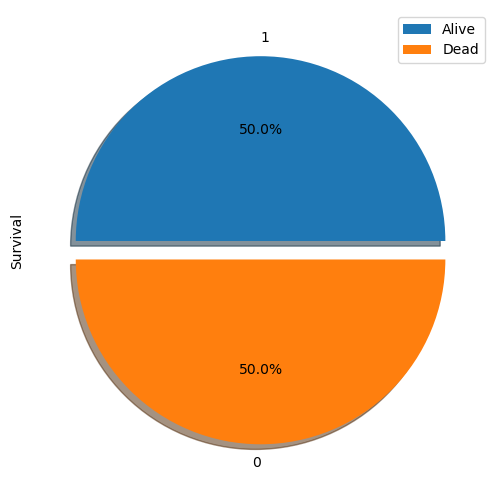

CPU times: total: 0 ns
Wall time: 65.5 ms


In [37]:
%%time
#Then adjust it using random undersampling (will reduce the DS by randomly picking results from the majority set)

X_train_cp = x_train_rs.copy()
X_train_cp['hospital_outcome_1alive_0dead'] = y_train_rs
y_0 = X_train_cp[X_train_cp['hospital_outcome_1alive_0dead'] == 1]
y_1 = X_train_cp[X_train_cp['hospital_outcome_1alive_0dead'] == 0]
y_0_undersample = y_0.sample(y_1.shape[0])
sepsis_data_undersample = pd.concat([y_0_undersample, y_1], axis = 0)

# Visualize the proportion of borrowers
show_data_balance(sepsis_data_undersample)
#Since this is medical data, and the balance is VERY skewed to survival, it would be more sensible to randomly sample, 
#rather than artificially generate false data.

In [38]:
%%time
#Excellent, the data is now balanced. We'll now use the variable sepsis_data_balanced instead of the original dataframe.

sepsis_data_balanced = sepsis_data_undersample

#and reassign x and y to the new values
x_rs = sepsis_data_balanced[['age_years', 'sex_0male_1female','episode_number']]
y_rs = sepsis_data_balanced['hospital_outcome_1alive_0dead']

#and check the counts
print(x_rs.count())
print(y_rs.count())

#Since we've redone the dataset to be balanced, now re-split the dataset
x_train_rs, x_test_rs, y_train_rs, y_test_rs = train_test_split(x_rs,y_rs,test_size =0.3)

#and check the counts again
print(x_train_rs.count())
print(y_train_rs.count())
#both should be 70% of x.count

age_years            11452
sex_0male_1female    11452
episode_number       11452
dtype: int64
11452
age_years            8016
sex_0male_1female    8016
episode_number       8016
dtype: int64
8016
CPU times: total: 0 ns
Wall time: 7.18 ms


In [39]:
%%time
# Let's try Model 1, a logistic Regression with random undersampling

# Now for the first model. Since this is a cut and dry binary classification task (dead or not dead), the first model to try 
#is the logistic regression. We've imported it above, so now let's create it
log_reg_rs = LogisticRegression()

#It's been created, so now we fit the model
log_reg_rs.fit(x_train_rs,y_train_rs)

CPU times: total: 15.6 ms
Wall time: 23 ms


LogisticRegression()

In [40]:
%%time
#great, we have a model! now, predict something

y_pred_rs = log_reg_rs.predict(x_test_rs)

CPU times: total: 15.6 ms
Wall time: 2.5 ms


In [41]:
%%time
#We've imported metrics up top, so now we can generate a confusion matrix on how well it did.
conf_matrix_rs = metrics.confusion_matrix(y_test_rs, y_pred_rs)
conf_matrix_rs

CPU times: total: 0 ns
Wall time: 1.99 ms


array([[1294,  418],
       [ 754,  970]], dtype=int64)

CPU times: total: 78.1 ms
Wall time: 80.8 ms


Text(0.5, 427.9555555555555, 'Predicted')

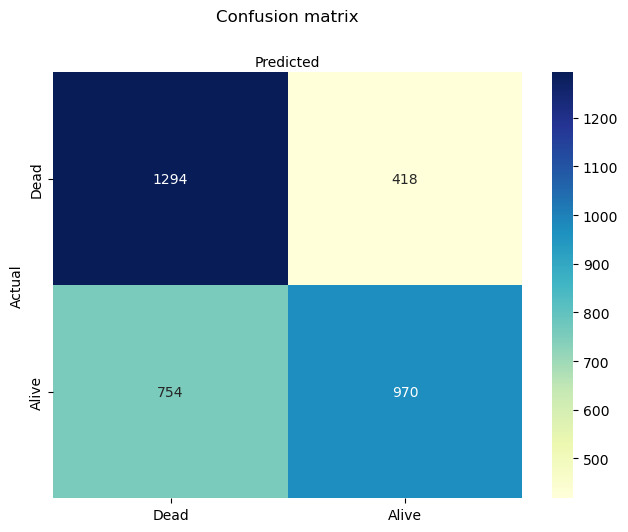

In [42]:
%%time
#Yikes, that doesn't look good. Let's make it pretty
class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_rs), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); 
ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#1 = alive, 0 = dead

In [73]:
%%time
# Cool, but let's quantify this in numbers
target_names = ['Dead','Alive']
print(metrics.classification_report(y_test_rs,y_pred_rs,target_names=target_names))

              precision    recall  f1-score   support

        Dead       0.63      0.76      0.69      1712
       Alive       0.70      0.56      0.62      1724

    accuracy                           0.66      3436
   macro avg       0.67      0.66      0.66      3436
weighted avg       0.67      0.66      0.66      3436

CPU times: total: 0 ns
Wall time: 13.2 ms


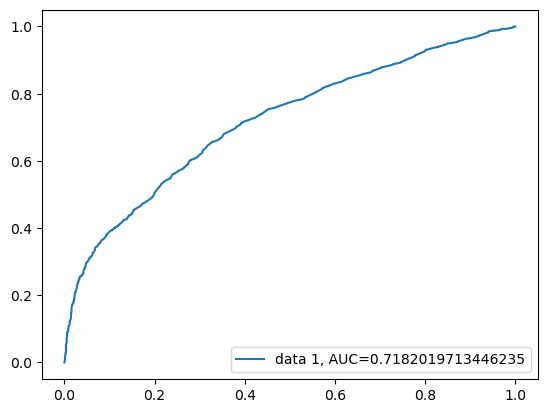

CPU times: total: 62.5 ms
Wall time: 84.6 ms


In [44]:
%%time
svm_disp = metrics.RocCurveDisplay.from_estimator(clf_rs, x_test_rs, y_test_rs)
plt.show()

In [45]:
# Let's try model 2, SVM

In [46]:
%%time
# Well, logistic regression was bad! Let's try SVM
clf_rs = svm.SVC(kernel = 'linear')
clf_rs = clf_rs.fit(x_train_rs,y_train_rs)
y_pred_svm_rs = clf.predict(x_test_rs)

CPU times: total: 6.28 s
Wall time: 10.7 s


In [47]:
%%time

print(metrics.classification_report(y_test_rs,y_pred_svm_rs,target_names=target_names))
conf_matrix_svm_rs = metrics.confusion_matrix(y_test_rs, y_pred_svm_rs)


              precision    recall  f1-score   support

        Dead       0.61      0.82      0.70      1712
       Alive       0.73      0.48      0.58      1724

    accuracy                           0.65      3436
   macro avg       0.67      0.65      0.64      3436
weighted avg       0.67      0.65      0.64      3436

CPU times: total: 0 ns
Wall time: 15.8 ms


CPU times: total: 0 ns
Wall time: 61.9 ms


Text(0.5, 427.9555555555555, 'Predicted')

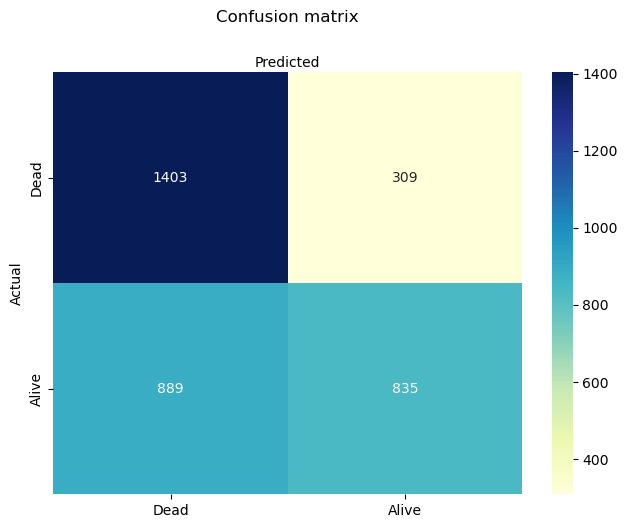

In [48]:
%%time

class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_svm_rs), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

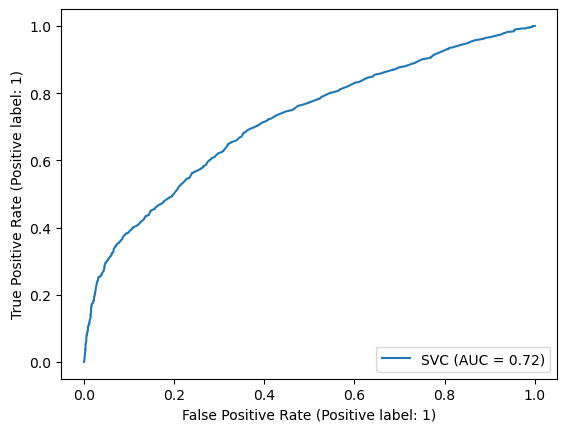

CPU times: total: 188 ms
Wall time: 434 ms


In [49]:
%%time

#Let's do a cheeky curve
svm_disp = metrics.RocCurveDisplay.from_estimator(clf_rs, x_test_rs, y_test_rs)
plt.show()

In [50]:
#Random Sampling, Model 3: Decision Tree

In [51]:
%%time

#That's even worse!! Let's do a decision tree
clf_tree_rs = DecisionTreeClassifier()
clf_tree_rs = clf_tree_rs.fit(x_train_rs, y_train_rs)
y_pred_tree_rs = clf_tree_rs.predict(x_test_rs)

CPU times: total: 0 ns
Wall time: 14 ms


In [84]:
from sklearn.tree import export_text
tree_rules = export_text(clf_tree_rs,

                        feature_names = ['age_years', 'sex_0male_1female','episode_number'])

print(tree_rules)

|--- age_years <= 61.50
|   |--- age_years <= 44.50
|   |   |--- episode_number <= 1.50
|   |   |   |--- age_years <= 37.50
|   |   |   |   |--- sex_0male_1female <= 0.50
|   |   |   |   |   |--- age_years <= 27.50
|   |   |   |   |   |   |--- age_years <= 23.50
|   |   |   |   |   |   |   |--- age_years <= 22.50
|   |   |   |   |   |   |   |   |--- age_years <= 19.50
|   |   |   |   |   |   |   |   |   |--- age_years <= 14.50
|   |   |   |   |   |   |   |   |   |   |--- age_years <= 8.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- age_years >  8.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- age_years >  14.50
|   |   |   |   |   |   |   |   |   |   |--- age_years <= 15.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- age_years >  15.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated bra

In [52]:
%%time

print(metrics.classification_report(y_test_rs,y_pred_tree_rs,target_names=target_names))
conf_matrix_tree_rs = metrics.confusion_matrix(y_test_rs, y_pred_tree_rs)

              precision    recall  f1-score   support

        Dead       0.61      0.76      0.68      1712
       Alive       0.69      0.53      0.60      1724

    accuracy                           0.64      3436
   macro avg       0.65      0.64      0.64      3436
weighted avg       0.65      0.64      0.64      3436

CPU times: total: 0 ns
Wall time: 14.1 ms


CPU times: total: 15.6 ms
Wall time: 63 ms


Text(0.5, 427.9555555555555, 'Predicted')

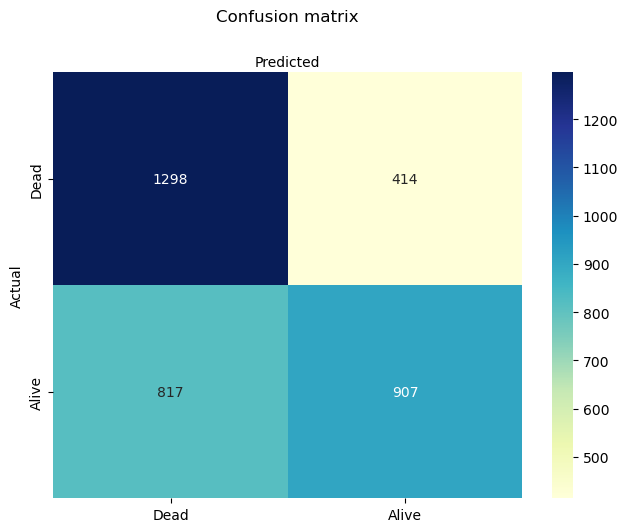

In [53]:
%%time

class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_tree_rs), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); 
ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

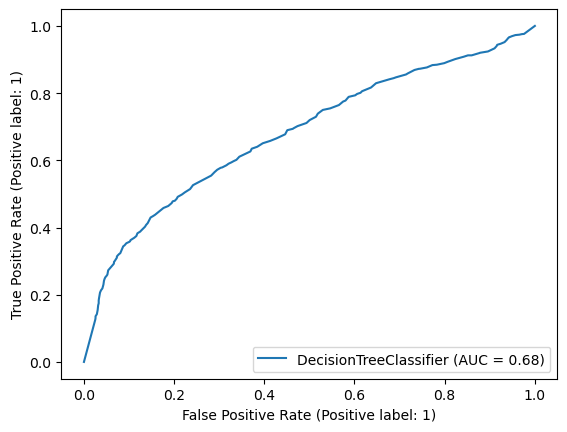

CPU times: total: 15.6 ms
Wall time: 97 ms


In [54]:
%%time

tree_disp_rs = metrics.RocCurveDisplay.from_estimator(clf_tree_rs, x_test_rs, y_test_rs)
plt.show()

In [55]:
#Random Sampling, Model 4: KNN

In [56]:
%%time

#These are just getting worse. Let's try KNN. 
scaler = preprocessing.StandardScaler()
x_train_scale_rs = scaler.fit_transform(x_train_rs)
x_test_scale_rs = scaler.transform(x_test_rs)

CPU times: total: 0 ns
Wall time: 3.5 ms


In [57]:
k_values = [i for i in range (1,100)]
scores = []


for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    score = model_selection.cross_val_score(knn, x_train_scale_rs, y_train_rs, cv=5)
    scores.append(np.mean(score))

CPU times: total: 15.6 ms
Wall time: 32.9 ms


Text(0, 0.5, 'Accuracy Score')

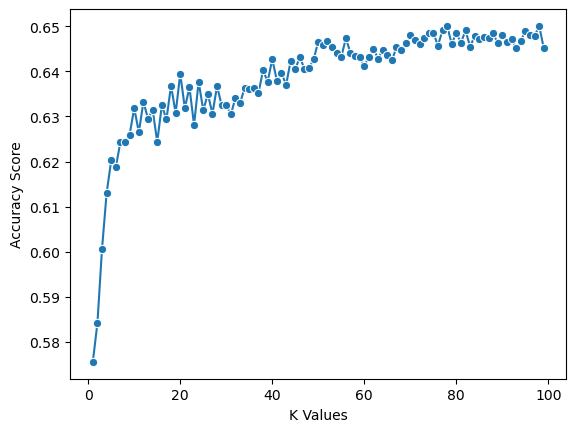

In [60]:
%%time
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [61]:

k_range = list(range(1,40))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)


knn = neighbors.KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(x_rs,y_rs)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.5510814147557099
{'n_neighbors': 38, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=38, weights='distance')


In [62]:
%%time

knn_rs = neighbors.KNeighborsClassifier(n_neighbors=38)
knn_rs.fit(x_train_scale_rs, y_train_rs)

CPU times: total: 0 ns
Wall time: 4.99 ms


KNeighborsClassifier(n_neighbors=38)

In [63]:
%%time

y_pred_knn_rs = knn_rs.predict(x_test_scale_rs)

CPU times: total: 62.5 ms
Wall time: 120 ms


In [64]:
%%time

print(metrics.classification_report(y_test_rs,y_pred_knn_rs,target_names=target_names))
conf_matrix_knn_rs = metrics.confusion_matrix(y_test_rs, y_pred_knn_rs)
print(metrics.accuracy_score(y_test_rs, y_pred_knn_rs))

              precision    recall  f1-score   support

        Dead       0.61      0.77      0.68      1712
       Alive       0.69      0.51      0.59      1724

    accuracy                           0.64      3436
   macro avg       0.65      0.64      0.63      3436
weighted avg       0.65      0.64      0.63      3436

0.639697322467986
CPU times: total: 0 ns
Wall time: 10.4 ms


CPU times: total: 31.2 ms
Wall time: 51 ms


Text(0.5, 427.9555555555555, 'Predicted')

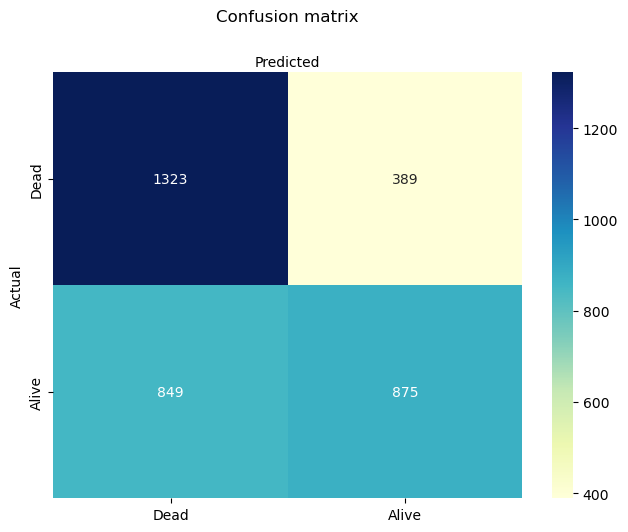

In [65]:
%%time
class_names = ['Dead','Alive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap time
sns.heatmap(pd.DataFrame(conf_matrix_knn_rs), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['Dead', 'Alive']); ax.yaxis.set_ticklabels(['Dead', 'Alive']);
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

C:\Users\jenni\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


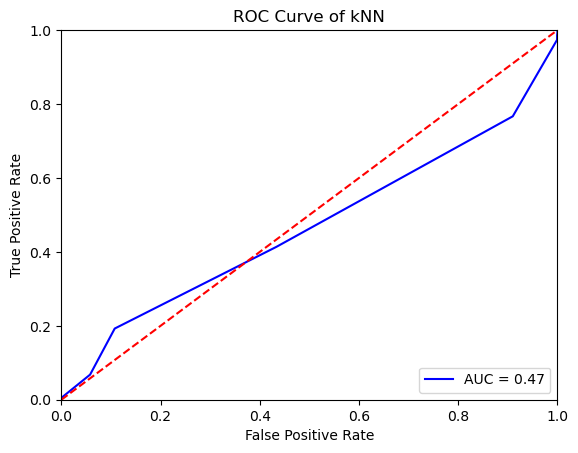

In [96]:
y_scores_rs = knn_rs.predict_proba(x_test_rs)
fpr, tpr, threshold = metrics.roc_curve(y_test_rs, y_scores_rs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [71]:
#Well, we've done it w/ smote and w/ random sampling. Let's evaluate every model and see what's what

#SMOTE first:

print("SMOTE - Logistic Regression:")
print(metrics.classification_report(y_test_smote,y_pred_logreg_smote,target_names=target_names))
print("AUC = 0.71")
print(metrics.accuracy_score(y_test_smote, y_pred_logreg_smote))
print("SMOTE - SVM:")
print(metrics.classification_report(y_test_smote,y_pred_svm_smote,target_names=target_names))
print("AUC = 0.70")
print(metrics.accuracy_score(y_test_smote, y_pred_svm_smote))
print("SMOTE - Decision Tree:")
print(metrics.classification_report(y_test_smote,y_pred_tree_smote,target_names=target_names))
print("AUC = 0.72")
print(metrics.accuracy_score(y_test_smote, y_pred_tree_smote))
print("SMOTE - KNN:")
print(metrics.classification_report(y_test_smote,y_pred_knn_smote,target_names=target_names))
print("AUC = None, it's a KNN")
print(metrics.accuracy_score(y_test_smote, y_pred_knn_smote))

SMOTE - Logistic Regression:
              precision    recall  f1-score   support

        Dead       0.62      0.74      0.68     30443
       Alive       0.68      0.56      0.62     30817

    accuracy                           0.65     61260
   macro avg       0.65      0.65      0.65     61260
weighted avg       0.65      0.65      0.65     61260

AUC = 0.71
0.6483512895853738
SMOTE - SVM:
              precision    recall  f1-score   support

        Dead       0.61      0.81      0.70     30443
       Alive       0.72      0.48      0.58     30817

    accuracy                           0.65     61260
   macro avg       0.66      0.65      0.64     61260
weighted avg       0.67      0.65      0.64     61260

AUC = 0.70
0.6460333006856024
SMOTE - Decision Tree:
              precision    recall  f1-score   support

        Dead       0.62      0.79      0.70     30443
       Alive       0.72      0.53      0.61     30817

    accuracy                           0.66     61260
   

In [74]:
print("Random Undersampling - Logistic Regression:")
print(metrics.classification_report(y_test_rs,y_pred_rs,target_names=target_names))
print("AUC = 0.72")
print(metrics.accuracy_score(y_test_rs, y_pred_rs))
print("Random Undersampling - SVM:")
print(metrics.classification_report(y_test_rs,y_pred_svm_rs,target_names=target_names))
print("AUC = 0.72")
print(metrics.accuracy_score(y_test_rs, y_pred_svm_rs))

print("Random Undersampling - Decision Tree:")
print(metrics.classification_report(y_test_rs,y_pred_tree_rs,target_names=target_names))
print("AUC = 0.68")
print(metrics.accuracy_score(y_test_rs, y_pred_tree_rs))

print("Random Undersampling - KNN:")
print(metrics.classification_report(y_test_rs,y_pred_knn_rs,target_names=target_names))
print(metrics.accuracy_score(y_test_rs, y_pred_knn_rs))


Random Undersampling - Logistic Regression:
              precision    recall  f1-score   support

        Dead       0.63      0.76      0.69      1712
       Alive       0.70      0.56      0.62      1724

    accuracy                           0.66      3436
   macro avg       0.67      0.66      0.66      3436
weighted avg       0.67      0.66      0.66      3436

AUC = 0.72
0.6589057043073341
Random Undersampling - SVM:
              precision    recall  f1-score   support

        Dead       0.61      0.82      0.70      1712
       Alive       0.73      0.48      0.58      1724

    accuracy                           0.65      3436
   macro avg       0.67      0.65      0.64      3436
weighted avg       0.67      0.65      0.64      3436

AUC = 0.72
0.6513387660069848
Random Undersampling - Decision Tree:
              precision    recall  f1-score   support

        Dead       0.61      0.76      0.68      1712
       Alive       0.69      0.53      0.60      1724

    accuracy

<IPython.core.display.Javascript object>